In [11]:
#ML Model for Loan Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the ratio of negative to positive classes for XGBoost
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import cross_validate,RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import random as rnd

# visualization
%matplotlib inline

# scaling and train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# creating a model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# evaluation on test data
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [12]:
#upload the files
file_path = 'D:/My files/deep learning/Mini Project/archive/train.csv'


df = pd.read_csv (file_path)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [13]:
cat_col=list(df.select_dtypes(include='object').columns)
temp=pd.DataFrame(columns=['Feature','cardinality'])
for i  in range(len(cat_col)):
    temp.loc[i,'Feature']=cat_col[i]
    temp.loc[i,'cardinality']=df[cat_col[i]].nunique()
temp.sort_values(by='cardinality',ascending=False).style.background_gradient(cmap='jet')

#remove unnecessary column
df_encode=df.drop(['Loan Title',"Accounts Delinquent",'Batch Enrolled','Sub Grade','Payment Plan','ID'],axis=1)
duplicate_rows = df_encode[df_encode.duplicated()]

# If duplicates are found, remove them
if not duplicate_rows.empty:
    df_encode = df_encode.drop_duplicates()
    
    #Check for constant columns (columns with a single unique value)
constant_columns = [col for col in df_encode.columns if df_encode[col].nunique() == 1]

# If constant columns are found, remove them
if constant_columns:
    df_encode = df_encode.drop(columns=constant_columns)

df_encode.shape, duplicate_rows.shape, constant_columns
    

((67463, 29), (0, 29), [])

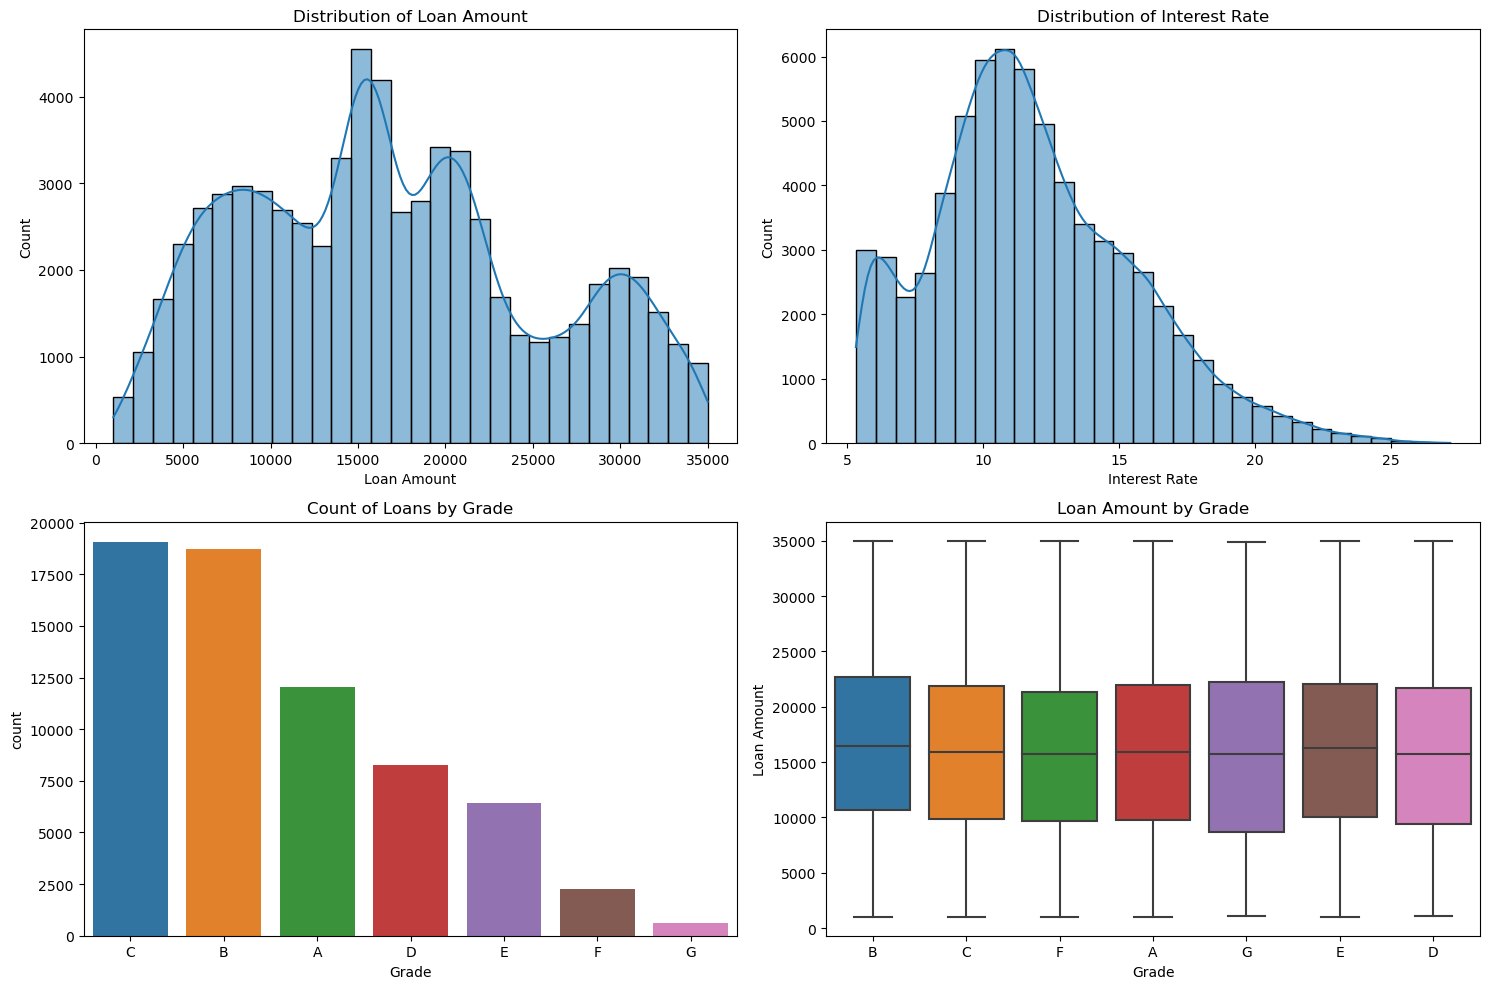

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,...,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,...,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,6.746300e+04,67463.000000,67463.000000
mean,16848.902776,15770.599114,14621.799323,58.173814,11.846258,80541.502522,23.299241,0.327127,0.145754,14.266561,...,2068.992542,1.143969,59.691578,1.125141,0.021301,71.163260,146.467990,1.595739e+05,23123.005544,0.092510
std,8367.865726,8150.992662,6785.345170,3.327441,3.718629,45029.120366,8.451824,0.800888,0.473291,6.225060,...,2221.918745,5.244365,357.026346,3.489885,0.144385,43.315845,744.382233,1.390332e+05,20916.699999,0.289747
min,1014.000000,1014.000000,1114.590204,36.000000,5.320006,14573.537170,0.675299,0.000000,0.000000,2.000000,...,4.736746,0.000003,0.000036,0.000036,0.000000,0.000000,1.000000,6.170000e+02,1000.000000,0.000000
25%,10012.000000,9266.500000,9831.684984,58.000000,9.297147,51689.843335,16.756416,0.000000,0.000000,10.000000,...,570.903814,0.021114,1.629818,0.476259,0.000000,35.000000,24.000000,5.037900e+04,8155.500000,0.000000
50%,16073.000000,13042.000000,12793.682170,59.000000,11.377696,69335.832680,22.656658,0.000000,0.000000,13.000000,...,1330.842771,0.043398,3.344524,0.780141,0.000000,68.000000,36.000000,1.183690e+05,16733.000000,0.000000
75%,22106.000000,21793.000000,17807.594120,59.000000,14.193533,94623.322785,30.048400,0.000000,0.000000,16.000000,...,2656.956837,0.071884,5.453727,1.070566,0.000000,105.000000,46.000000,2.283750e+05,32146.500000,0.000000
max,35000.000000,34999.000000,34999.746430,59.000000,27.182348,406561.536400,39.629862,8.000000,5.000000,37.000000,...,14301.368310,42.618882,4354.467419,166.833000,1.000000,161.000000,16421.000000,1.177412e+06,201169.000000,1.000000


In [14]:
# 2. Descriptive Statistics & Data Visualization

# Descriptive statistics for numerical columns
desc_stats = df_encode.describe()

# Visualization of the distribution of some key numerical columns
plt.figure(figsize=(15, 10))

# Histogram for "Loan Amount"
plt.subplot(2, 2, 1)
sns.histplot(df_encode['Loan Amount'], kde=True, bins=30)
plt.title('Distribution of Loan Amount')

# Histogram for "Interest Rate"
plt.subplot(2, 2, 2)
sns.histplot(df_encode['Interest Rate'], kde=True, bins=30)
plt.title('Distribution of Interest Rate')

# Bar plot for "Grade"
plt.subplot(2, 2, 3)
sns.countplot(data=df_encode, x='Grade', order=df_encode['Grade'].value_counts().index)
plt.title('Count of Loans by Grade')

# Box plot for "Loan Amount" by "Grade"
plt.subplot(2, 2, 4)
sns.boxplot(data=df_encode, x='Grade', y='Loan Amount')
plt.title('Loan Amount by Grade')

plt.tight_layout()
plt.show()

desc_stats


In [15]:
import os
data_types = df_encode.dtypes

# Extracting columns that are of type 'object' to check for potential inconsistencies
object_columns = data_types[data_types == 'object'].index

# Displaying unique values for each object column to identify any inconsistencies
unique_values_in_object_columns = {col: df_encode[col].unique() for col in object_columns}

unique_values_in_object_columns

# Extracting columns that are of type 'object' to check for potential inconsistencies
object_columns = df_encode.select_dtypes(include=['object']).columns

# Creating a new DataFrame with one-hot encoding for object columns
df_encoded = pd.get_dummies(df_encode, columns=object_columns)

# Displaying the first few rows of the resulting DataFrame
print(df_encoded.head())


   Loan Amount  Funded Amount  Funded Amount Investor  Term  Interest Rate  \
0        10000          32236             12329.36286    59      11.135007   
1         3609          11940             12191.99692    59      12.237563   
2        28276           9311             21603.22455    59      12.545884   
3        11170           6954             17877.15585    59      16.731201   
4        16890          13226             13539.92667    59      15.008300   

   Home Ownership  Debit to Income  Delinquency - two years  \
0    176346.62670        16.284758                        1   
1     39833.92100        15.412409                        0   
2     91506.69105        28.137619                        0   
3    108286.57590        18.043730                        1   
4     44234.82545        17.209886                        1   

   Inquires - six months  Open Account  ...  Employment Duration_MORTGAGE  \
0                      0            13  ...                          True  

In [16]:
df=pd.get_dummies(df_encode,columns=['Term', 'Grade', 'Employment Duration', 'Verification Status',
       'Initial List Status', 'Application Type'],drop_first=True)
print(df.columns)

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
       'Interest Rate', 'Home Ownership', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Total Received Interest', 'Total Received Late Fee',
       'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical',
       'Last week Pay', 'Total Collection Amount', 'Total Current Balance',
       'Total Revolving Credit Limit', 'Loan Status', 'Term_58', 'Term_59',
       'Grade_B', 'Grade_C', 'Grade_D', 'Grade_E', 'Grade_F', 'Grade_G',
       'Employment Duration_OWN', 'Employment Duration_RENT',
       'Verification Status_Source Verified', 'Verification Status_Verified',
       'Initial List Status_w', 'Application Type_JOINT'],
      dtype='object')


In [17]:
# Separate features and target variable
X = df.drop(columns=['Loan Status'])
y = df['Loan Status']
smote=SMOTE()
smote.fit(X,y)
X,y=smote.fit_resample(X,y)
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}
results = []


In [18]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append([name, accuracy, precision, recall, f1, roc_auc])

E:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
E:\Anaconda\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


In [19]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])
print(results_df)

                      Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0    Balanced Random Forest  0.920658   0.983925  0.852795  0.913679  0.960779
1  Random Forest Classifier  0.921189   0.984223  0.853624  0.914283  0.961236
2                  AdaBoost  0.848503   0.852832  0.836706  0.844692  0.914973
3         Gradient Boosting  0.871493   0.971033  0.761735  0.853744  0.922353
4       Logistic Regression  0.515048   0.508875  0.432742  0.467730  0.526054


In [20]:
param_dist = {
    'n_estimators': [10, 50, 70],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    }

# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Random search of parameters using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=2, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Best parameters
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


E:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [21]:
best_params={'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

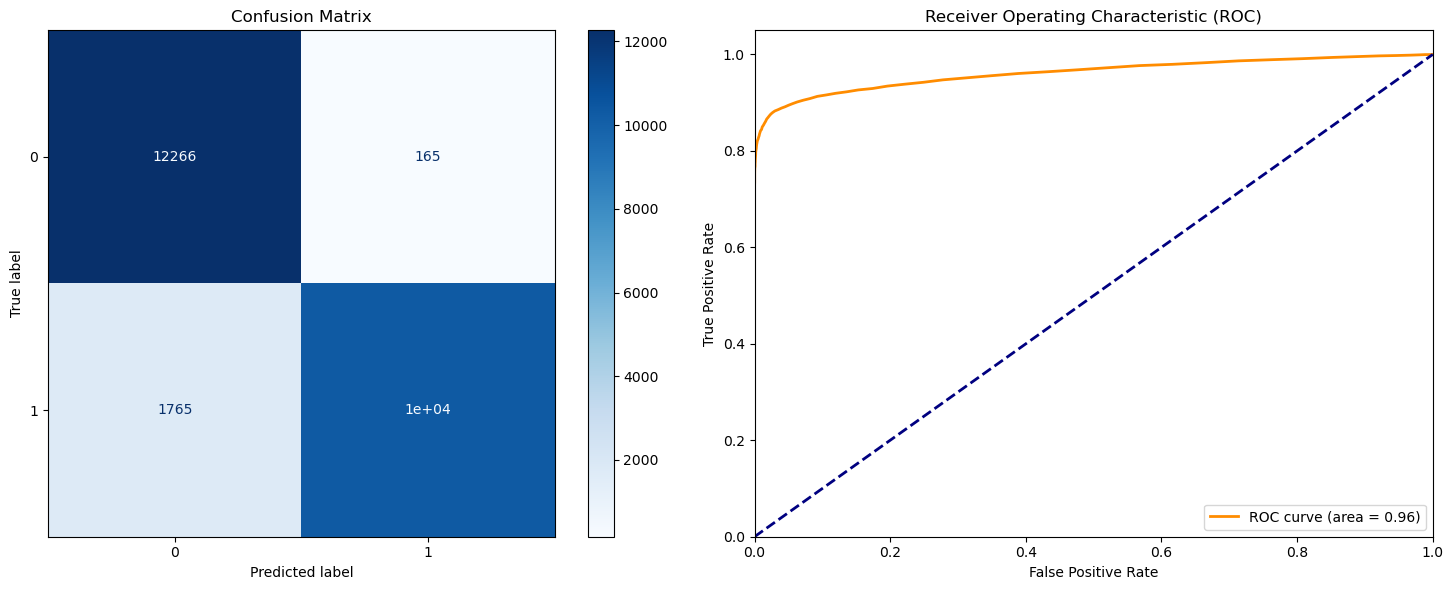

In [22]:
# Evaluate the model
# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix')

# ROC AUC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, 
          label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate') 
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [23]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
    
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%") 
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"ROC AUC: {roc_auc*100:.2f}%")


Accuracy: 92.12%
Precision: 98.42%
Recall: 85.36%
F1 Score: 91.43%
ROC AUC: 96.12%


In [24]:
#lOAN_ PREDICITION USING ANN

# Features
X = df.drop('Loan Status',axis=1).values

# Label
y = df['Loan Status'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(53970, 36)
(13493, 36)
(53970,)
(13493,)


In [25]:
scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# everything has been scaled between 1 and 0
print('Max: ',X_train.max())
print('Min: ', X_train.min())

model = Sequential()

# input layer
model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer="adam", loss='binary_crossentropy')



Max:  1.0000000000000002
Min:  0.0




Epoch 1/400

211/211 - 3s - loss: 0.3474 - val_loss: 0.3199 - 3s/epoch - 14ms/step
Epoch 2/400
211/211 - 0s - loss: 0.3179 - val_loss: 0.3184 - 474ms/epoch - 2ms/step
Epoch 3/400
211/211 - 0s - loss: 0.3148 - val_loss: 0.3182 - 462ms/epoch - 2ms/step
Epoch 4/400
211/211 - 0s - loss: 0.3140 - val_loss: 0.3194 - 467ms/epoch - 2ms/step
Epoch 5/400
211/211 - 0s - loss: 0.3122 - val_loss: 0.3183 - 467ms/epoch - 2ms/step
Epoch 6/400
211/211 - 0s - loss: 0.3126 - val_loss: 0.3183 - 455ms/epoch - 2ms/step
Epoch 7/400
211/211 - 0s - loss: 0.3107 - val_loss: 0.3182 - 448ms/epoch - 2ms/step
Epoch 8/400
211/211 - 0s - loss: 0.3093 - val_loss: 0.3183 - 467ms/epoch - 2ms/step
Epoch 9/400
211/211 - 0s - loss: 0.3085 - val_loss: 0.3182 - 449ms/epoch - 2ms/step
Epoch 10/400
211/211 - 0s - loss: 0.3081 - val_loss: 0.3196 - 451ms/epoch - 2ms/step
Epoch 11/400
211/211 - 0s - loss: 0.3088 - val_loss: 0.3183 - 456ms/epoch - 2ms/step
Epoch 12/400
211/211 - 0s - loss: 0.3077 - val_loss: 0.3186 - 464ms/epoch -

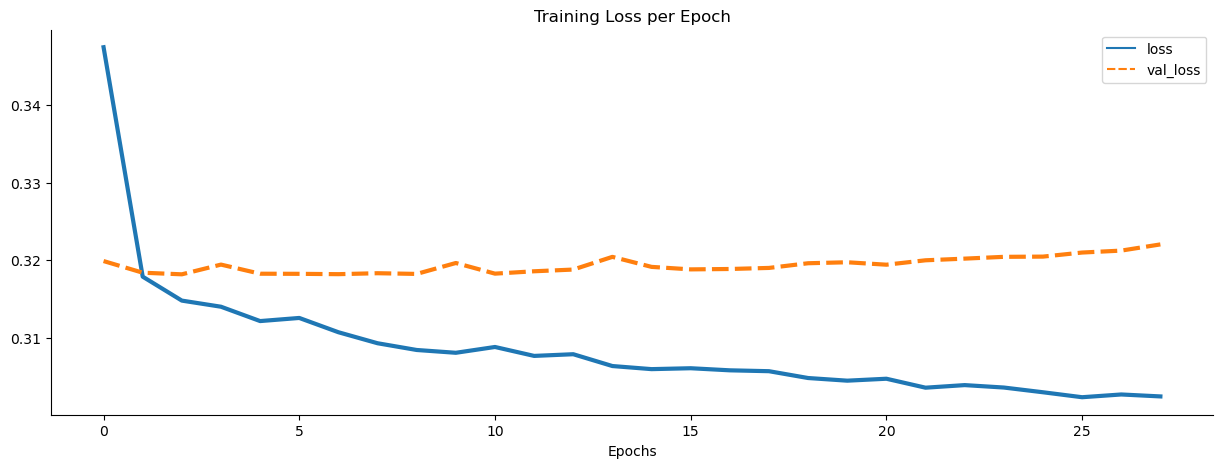

In [26]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          verbose = 2,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

In [27]:

#'model' is your trained Keras Sequential model
predictions_probabilities = model.predict(X_test)
predictions_classes = (predictions_probabilities > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_classes)

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy: {:.2%}".format(accuracy))


422/422 [==============================] - 0s 856us/step
Confusion Matrix:
[[12190     0]
 [ 1303     0]]

Accuracy: 90.34%


In [34]:
# LOAN PREDICTION USING RNN

file_path = 'D:/My files/deep learning/Mini Project/archive/train.csv'
data = pd.read_csv (file_path)
target_column = 'Loan Status'
# Drop any columns that are not relevant for prediction
data = data.drop(columns=['Loan Title',"Accounts Delinquent",'Batch Enrolled','Sub Grade','Payment Plan','ID'])  # Add columns to be dropped

# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

# Split data into features (X) and target variable (y)
X = data.drop(columns=[target_column])
y = data[target_column]



# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for RNN (assuming each row is a time step)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [35]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
1687/1687 [==============================] - 4s 2ms/step - loss: 0.3214 - accuracy: 0.9058 - val_loss: 0.3081 - val_accuracy: 0.9097
Epoch 2/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3121 - accuracy: 0.9069 - val_loss: 0.3089 - val_accuracy: 0.9097
Epoch 3/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3102 - accuracy: 0.9069 - val_loss: 0.3063 - val_accuracy: 0.9097
Epoch 4/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3091 - accuracy: 0.9069 - val_loss: 0.3070 - val_accuracy: 0.9097
Epoch 5/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3078 - accuracy: 0.9069 - val_loss: 0.3073 - val_accuracy: 0.9097
Epoch 6/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3074 - accuracy: 0.9070 - val_loss: 0.3065 - val_accuracy: 0.9097
Epoch 7/10
1687/1687 [==============================] - 2s 1ms/step - loss: 0.3067 - accuracy: 0.9069 - val_loss: 0.3055 - val_accuracy:

In [36]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(X_test)

# Assuming a binary classification problem (e.g., 'Charged Off' or 'Fully Paid')
# Convert probabilities to class labels (0 or 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate and print accuracy on the test set in percentage format
test_accuracy = np.mean(predicted_labels.squeeze() == y_test.values)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model if needed
# model.save('loan_prediction_rnn_model.h5')



422/422 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.9097
Test Loss: 0.3073, Test Accuracy: 90.97%
422/422 [==============================] - 1s 939us/step
Test Accuracy: 90.97%


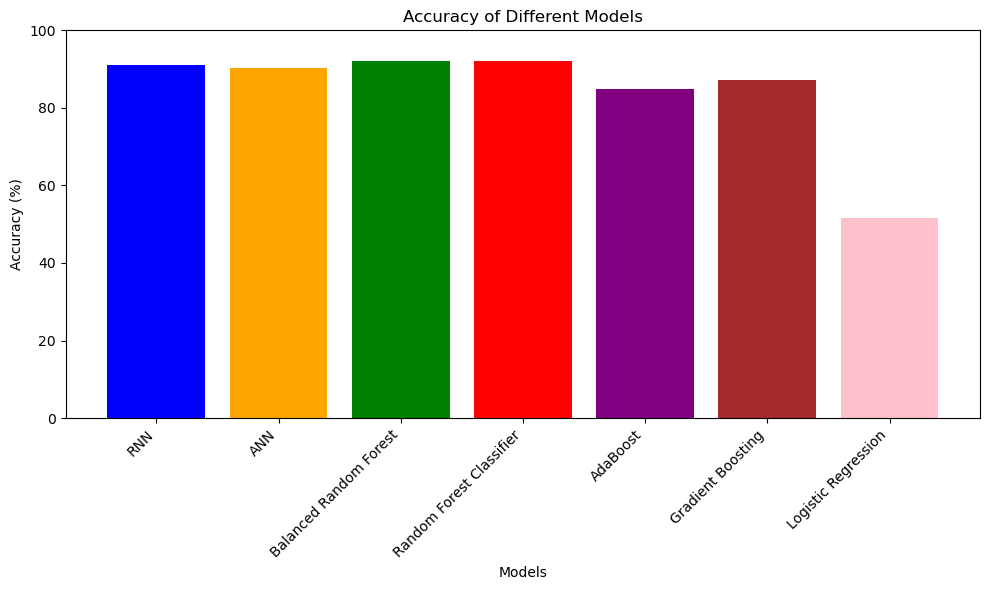

In [37]:
#Visualisation of Models
import matplotlib.pyplot as plt

# Model names
models = ['RNN', 'ANN', 'Balanced Random Forest', 'Random Forest Classifier', 'AdaBoost', 'Gradient Boosting', 'Logistic Regression']

# Corresponding accuracies
accuracies = [90.97, 90.34, 92.07, 92.12, 84.85, 87.15, 51.50]  # Replace these values with your actual accuracy values

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(0, 100)  # Set the y-axis range from 0 to 100
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better appearance

# Show the plot
plt.show()
